In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

First, read in the data. The data comes from Kaggle: https://www.kaggle.com/c/demand-forecasting-kernels-only

The data is time-series, split into training (2013-2017) and testing (2018 - ), where testing has NaN in the target column. We will combine the two for now so we can engineer features on both sets simultaneously, then split them.

In [2]:
train = pd.read_csv('../dat/train.csv')
test = pd.read_csv('../dat/test.csv')
df = pd.concat([train,test],sort=True)
## Convert the date column from string to datetime
df['date'] = pd.to_datetime(df['date'])
## Then extract the date values for each entry
df['year'] = df['date'].map(lambda x:x.year)
df['month'] = df['date'].map(lambda x:x.month)
df['day'] = df['date'].map(lambda x:x.day)
df['dayofweek'] = df['date'].map(lambda x:x.dayofweek)
df['weekofyear'] = df['date'].map(lambda x:x.weekofyear)
df.head()
## Split back into train and test, while dropping the unnecessary 'id' column
train = df.drop(labels = 'id', axis=1)[pd.isna(df['id'])]
test = df[pd.isna(df['sales'])]

## Visualizations

#### Total Sales by Day (2013-2017) (All items, all stores)

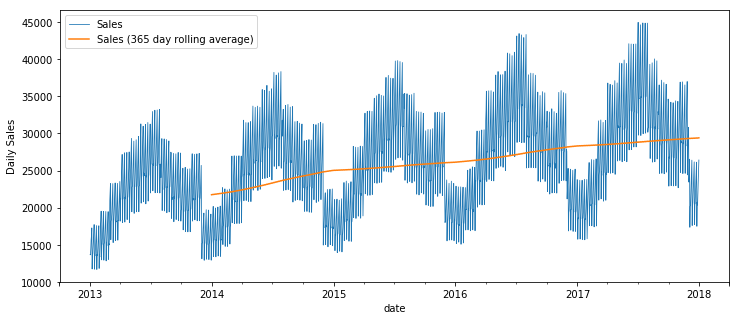

In [31]:
ax = train.groupby('date').sum()['sales'].plot.line(
    figsize = (12,5),
    linewidth = 0.8
)
train.groupby('date').sum()['sales'].rolling(365).mean().plot.line()
ax.set_ylabel('Daily Sales')
lines,_ = ax.get_legend_handles_labels()
ax.legend(lines, ['Sales','Sales (365 day rolling average)'])

This plot tells us that there is a pretty clear seasonality effect to this time series, with a period of about 1 year. There is also a slight upwards trend - the mean increases every year, as indicated by the rolling average line..

#### Total Sales by Day (2016)

[Text(0,0.5,'Daily Sales'), Text(0.5,1,'Daily Sales for 2016')]

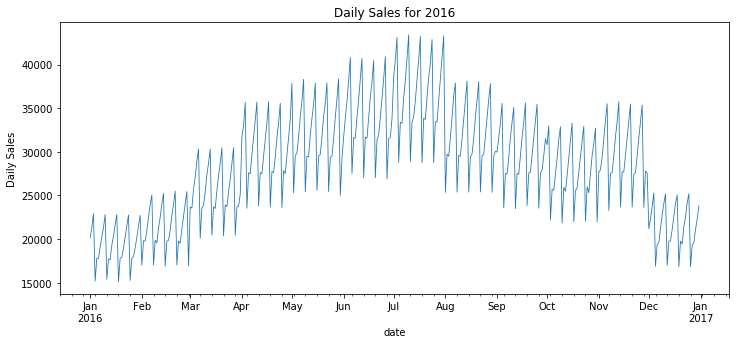

In [43]:
ax = train[train['year'] == 2016].groupby('date').sum()['sales'].plot.line(
    figsize = (12,5),
    linewidth = 0.8
)
ax.set(ylabel = 'Daily Sales', title = 'Daily Sales for 2016')

When we zoom in to a single year, we see an odd pattern: the fluctuations within a given month remain fairly uniform, and then jump at the start of the next month, almost as if the values are discrete. What happens when we zoom in to a particular month:

[Text(0,0.5,'Daily Sales'), Text(0.5,1,'Total Sales for June/July 2016')]

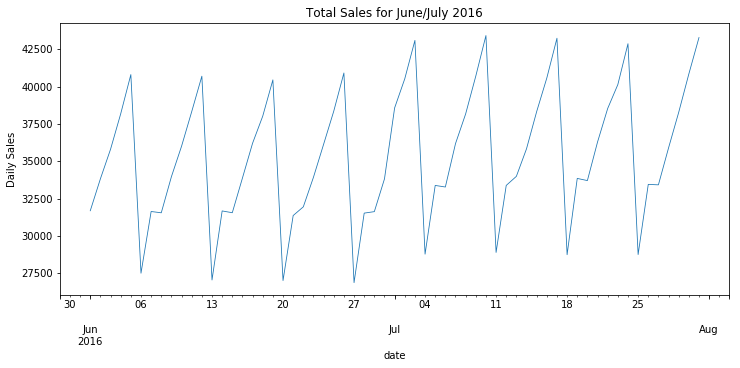

In [42]:
ax = train[(train['year'] == 2016) & (train['month'].isin([6,7]))].groupby('date').sum()['sales'].plot.line(
    figsize = (12,5),
    linewidth = 0.8
)
ax.set(ylabel = 'Daily Sales', title = 'Daily Sales for June/July 2016')

Zooming in, there is a pretty clear weekly seasonal pattern on top of the yearly seasonal pattern. In addition, we can see that the weekly fluctuations within a given month are identical in peak, trough, and mean.

Since the variance in a given month appears to be constant, that tells us that the sales within that month is essentially determined by the mean sales for that month. So, if we wanted to predict sales over a time period of at least a month, we could probably just use the aggregate monthly sales instead of daily sales as our data.

#### Total Sales by Month

[Text(0,0.5,'Monthly Sales')]

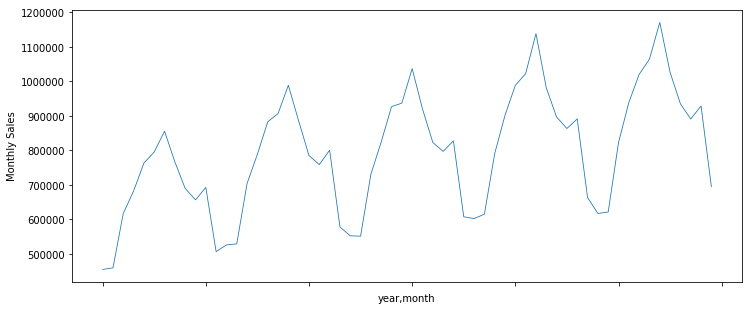

In [46]:
ax = train.groupby(['year','month']).sum()['sales'].plot.line(
    figsize = (12,5),
    linewidth = 0.8
)
ax.set(ylabel = 'Monthly Sales')

If we aggregate sales over the entire month, we get a similar graph, without the extraneous noise caused by the weekly fluctuations. We still observe the yearly seasonal fluctuation and overall increasing trend.

#### Daily Sales by Item/by Store

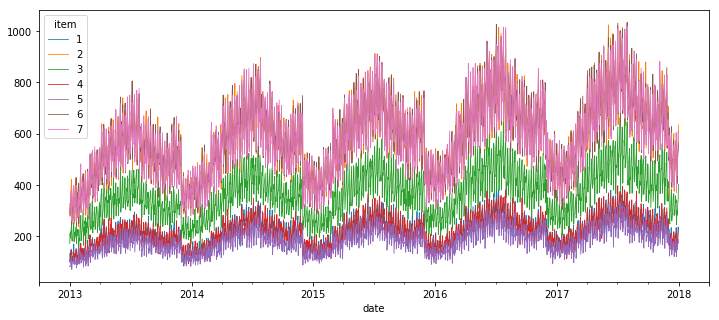

In [56]:
ax = train[train['item'].isin(list(range(1,8)))].groupby(['date','item']).sum()['sales'].unstack().plot.line(
    figsize = (12,5),
    linewidth = 0.8
)
ax.set(ylabel = 'Daily Sales')

[Text(0,0.5,'Daily Sales')]

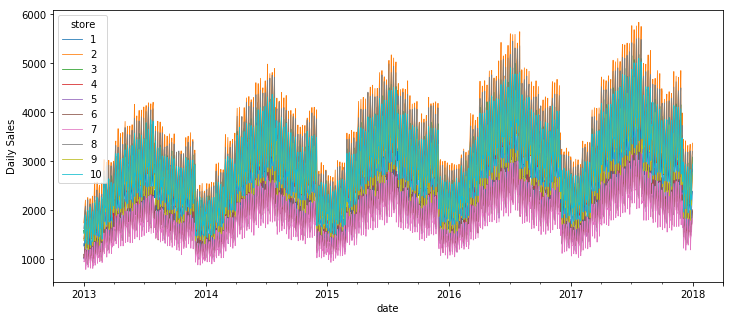

In [57]:
ax = train.groupby(['date','store']).sum()['sales'].unstack().plot.line(
    figsize = (12,5),
    linewidth = 0.8
)
ax.set(ylabel = 'Daily Sales')

In case we want to predict sales per item or per store, we can check the sales distributions amongst the various stores and items to see if they differ from our aggregate plot. It appears that they don't: the individual items and stores follow the same seasonal pattern and upwards trend.

We can even see if the individual items follow the same weekly pattern:

[Text(0,0.5,'Daily Sales'), Text(0.5,1,'Daily Sales by Store in June 2016')]

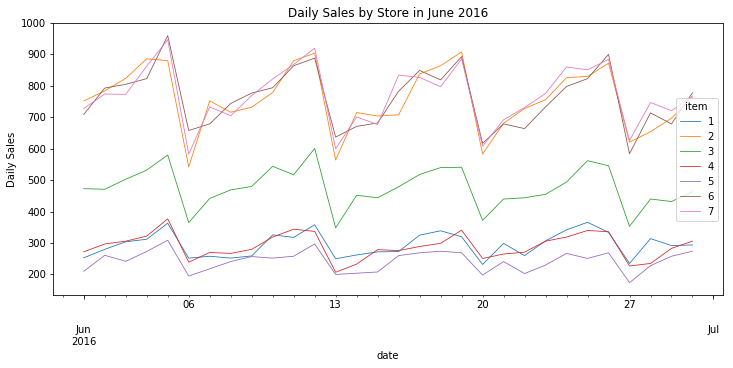

In [62]:
ax = train[(train['year'] == 2016) & (train['month'] == 6) & (train['item'].isin(list(range(1,8))))].groupby(['date','item']).sum()['sales'].unstack().plot.line(
    figsize = (12,5),
    linewidth = 0.8
)
ax.set(ylabel = 'Daily Sales', title = 'Daily Sales by Store in June 2016')

Yep, it looks like even the individual items follow the same weekly pattern, and also don't fluctuate within a given month.

Since the sales of each item don't seem to change relative to one another (i.e. item 7 is consistently selling 400 more units per day than item 3), we could conceivably predict the sales for individual items by first predicting total sales, then dividing the total sales up by the appropriate ratio of sales per item, rather than making separate predictions for each item individually.

## Predictions

### ARIMA

We will start by using seasonal ARIMA to see if we can forecast total sales by month. We will use pyramid.arima's auto_arima method to automatically determine the ARIMA parameters.

In [3]:
from pyramid.arima import auto_arima

In [4]:
def arima_plot(data, n_periods, freq, arima_params = None):
    """
    data: pass in time series data as a dataframe that is indexed by datetime, and with a single column of y values
    
    n_periods: number of periods into the future (after the last date index of the data) to forecast
    
    freq: data frequency. 'D' for daily, 'MS' for monthly, etc.
    
    arima_params: pass in a dictionary of parameters for the pyramid.arima.auto_arima method.
                  If arima_params=None, a default set of params is provided.
    """
    if arima_params is None:
        arima_params = {'suppress_warnings':True,'error_action':'ignore',
                       'start_p':0,'max_p':12,
                       'start_q':0,'max_q':12,
                       'start_P':0,'max_P':12,
                       'start_Q':0,'max_Q':12,
                       'd':1,'D':1,
                       'seasonal':True,'m':12}
    model = auto_arima(y=data, **arima_params)
    model.fit(data)
    pred = pd.DataFrame(data = model.predict(n_periods),
                        index = pd.date_range(start = data.index[-1], periods = n_periods+1, freq=freq)[1:],
                        columns = ['Prediction'])
    total = pd.concat([data,pred], axis = 1)
    total.loc[data.index[-1]]['Prediction'] = data.loc[data.index[-1]].values[0]
    total.plot.line(figsize=(12,4))
    return(pred)

In [5]:
monthly = train.groupby(['year','month']).sum()['sales'].reset_index()
monthly.index = pd.to_datetime(monthly['year'].map(str) + '-' + monthly['month'].map(str) + '-' + '01')
monthly.drop(['year','month'], inplace = True, axis=1)

,Prediction
2018-01-01,6.433682e+05
2018-02-01,6.455916e+05
2018-03-01,8.490628e+05
2018-04-01,9.650291e+05
2018-05-01,1.045429e+06
2018-06-01,1.089717e+06
2018-07-01,1.194548e+06
2018-08-01,1.050172e+06
2018-09-01,9.574270e+05
2018-10-01,9.111933e+05


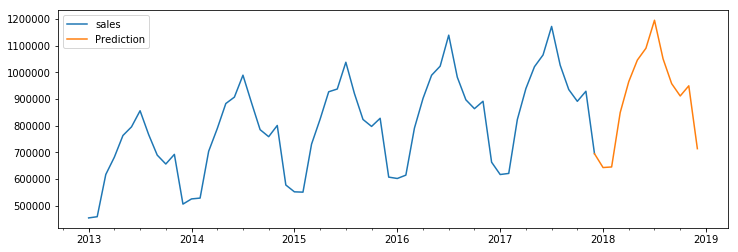

In [6]:
arima_plot(data = monthly, n_periods = 12, freq = 'MS')

Looks like ARIMA did a pretty good job at capturing the trends in our data: it matches the shape of the yearly fluctuation exactly, and gives the slight upwards trend that we observed in the data.

Next, we'll see how the ARIMA model does when we give it the larger and noiser sales-by-day dataset.

One thing we have to account for is the multiple seasonalities in the daily dataset: we have a weekly seasonality and a yearly seasonality. Since ARIMA in python doesn't allow you to account for multiple seasonalities, we have to pick one to model off of, and it's not clear which one we should pick. So we'll try both; we'll create an ARIMA model with a seasonality of 7 and a seasonality of 365, and see how each performs on a subset of the data.

In [9]:
daily_sub = pd.DataFrame(train.groupby('date').sum()['sales']).head(370)

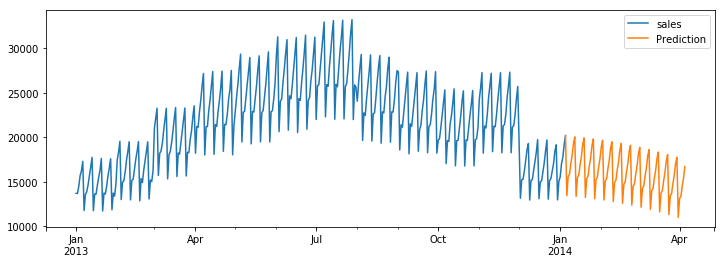

In [11]:
## Seasonality m=7 (week)
arima_params7 = {'suppress_warnings':True,'error_action':'ignore',
                       'start_p':1,'max_p':5,
                       'start_q':1,'max_q':5,
                       'start_P':1,'max_P':5,
                       'start_Q':1,'max_Q':5,
                       'd':None,'D':1,
                       'seasonal':True,'m':7}
_ = arima_plot(data = daily_sub, n_periods = 90, freq = 'D', arima_params=arima_params7)

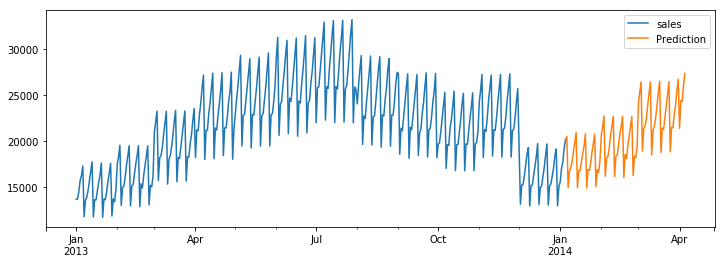

In [12]:
## Seasonality m=365 (year)
arima_params365 = {'suppress_warnings':True,'error_action':'ignore',
                       'start_p':1,'max_p':5,
                       'start_q':1,'max_q':5,
                       'start_P':1,'max_P':5,
                       'start_Q':1,'max_Q':5,
                       'd':None,'D':1,
                       'seasonal':True,'m':365}
_ = arima_plot(data = daily_sub, n_periods = 90, freq = 'D', arima_params=arima_params365)

The 7-day seasonality model accurately reflects the shape of the weekly trend, but it doesn't reflect the yearly trend. Rather, it seems to slowly trend downwards, probably because the yearly trend at the end of the training period is trending downwards.

The 365-day model does appear to capture both the yearly and weekly shape. Since it's a 365-day model, I believe it's returning an accurate weekly shape because it's "copying" the trend from the training data. This shouldn't be a problem, since we've seen that the weekly trends are very uniform throughout the data. What's most important is that the model captures the shape of the yearly trend, and the "jumps" between months. We would also expect this model to capture the slight upwards trend across multiple years, if given more training data.

Overall, ARIMA has been successful at fitting the data accurately. However, the process of finding parameters for ARIMA is time- and resource-intensive, and applying ARIMA to a dataset with thousands of points or more is too slow. Therefore, we will move on to trying other models that hopefully give us better performance.